In [1]:
import random
import pandas as pd

random.seed(1729)

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('waitlist_kidney_brazil_prepared_sensitive.csv', encoding='iso-8859-1')
df.head()

,date_registered,age_registered,dialysis_session_count,sex,race,underlying_disease,diabetes,chagas,blood_type,transfusion_count,...,hla_dr1,hla_dr2,dr_00,b_00,a_00,anti_hbc,anti_hcv,hbs_ag,event,days_waiting
0,2017-06-29,67,1.0,M,Branca,other,True,False,A,0,...,3,7,heterozygous,heterozygous,heterozygous,False,False,False,waiting,392
1,2008-11-03,58,4.0,M,Branca,diabetes,False,False,A,0,...,11,0,homozygous,heterozygous,heterozygous,False,False,False,died_waiting,2066
2,2010-07-13,51,2.0,M,Branca,hypertension,True,False,O,0,...,1,15,heterozygous,heterozygous,heterozygous,False,False,False,removed,365
3,2011-10-03,52,17.0,M,Branca,diabetes,False,False,O,0,...,1,15,heterozygous,heterozygous,heterozygous,False,False,False,removed,365
4,2006-07-05,67,68.0,M,Parda,hypertension,True,False,A,0,...,13,15,heterozygous,heterozygous,heterozygous,False,False,False,died_waiting,194


In [4]:
def clean(df: pd.DataFrame) -> pd.DataFrame:
    df_clean = df[df['event'] == 'transplanted'].copy()
    df_clean.drop(columns=['event'], inplace=True)
    df_clean['date_registered'] = \
        pd.to_datetime(df['date_registered']).astype(int) / (1e9 * 3600 * 24)
    df_clean['date_transplanted'] = \
        pd.to_datetime(df['date_registered']) + pd.to_timedelta(df_clean['days_waiting'], 'days')
    return df_clean


def onehot_encode(df: pd.DataFrame) -> pd.DataFrame:
    df_onehot = pd.get_dummies(
        df,
        columns=list(set([
            'sex',
            'race',
            'underlying_disease',
            'blood_type',
            'dr_00',
            'b_00',
            'a_00'
        ]) & set(df.columns)),
        drop_first=True
    )
    df_onehot['race'] = df['race']
    df_onehot['sex'] = df['sex']
    return df_onehot


def train_test_split(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    df = df.copy()
    N = df.shape[0]
    N_train = N * 80 // 100
    df.sort_values(by='date_registered', inplace=True, ignore_index=True)
    return df.iloc[:N_train], df[N_train:]


from fairlearn.preprocessing import CorrelationRemover


def remove_correlation(df: pd.DataFrame, *, correlation_remover = None) -> pd.DataFrame:
    sensitive_features = ['sex_M', 'race_Branca', 'race_Parda', 'race_Negra']
    if correlation_remover is None:
        correlation_remover = CorrelationRemover(sensitive_feature_ids=sensitive_features)
    meta = ['race', 'sex', 'date_registered', 'date_transplanted']
    mesa = df.drop(columns=meta) # Vide Cheal, Joe. "What is the opposite of meta?." ANLP Acuity Vol 2 (2011).
    data = correlation_remover.fit_transform(mesa)
    return pd.concat(
        [
            pd.DataFrame(data, index=mesa.index, columns=[col for col in mesa.columns if not col in sensitive_features]),
            df[meta],
            # df[sensitive_features] # Não faz sentido adicionar de volta, né?
        ],
        axis=1
    ), correlation_remover


def augment_df(df: pd.DataFrame) -> pd.DataFrame:
    return df
    sensitive_features = ['sex', 'race']
    groups = df.groupby(sensitive_features)
    big = groups.count().max().max()
    return pd.concat(
        [
            pd.concat([data, data.sample(big - data.shape[0], replace=True, random_state=1729)])
            for _, data in groups
        ]
    )


df_people = onehot_encode(clean(df))
df_people_train, df_people_test = train_test_split(df_people)
df_people_train_uncorrelated, remover = remove_correlation(augment_df(df_people_train))
df_people_test_uncorrelated, _ = remove_correlation(df_people_test, correlation_remover=remover)
df_people_train_uncorrelated.head()

,age_registered,dialysis_session_count,diabetes,chagas,transfusion_count,gestation,prior_transplant,c_pra,hla_a1,hla_a2,...,a_00_homozygous,dr_00_homozygous,underlying_disease_glomerulonephritis,underlying_disease_hypertension,underlying_disease_other,underlying_disease_pyelonephritis,race,sex,date_registered,date_transplanted
0,-92.579005,-58.700625,-2.698233,0.0,-1.301101,-0.786908,-0.324948,-23.323957,-11.906148,-62.613581,...,-0.356975,-0.150369,-0.647694,-0.918396,-1.050267,-0.081876,Amarela,M,10959.0,2004-01-21
1,-0.041522,-5.766981,0.325496,0.0,-0.337311,-0.492080,-0.088624,-12.042648,-4.173059,10.889024,...,-0.076394,-0.037583,-0.188164,-0.138999,0.680715,-0.028057,Branca,F,10962.0,2012-06-20
2,7.958478,-11.766981,0.325496,0.0,0.662689,0.507920,-0.088624,52.957352,-4.173059,48.889024,...,-0.076394,-0.037583,-0.188164,0.861001,-0.319285,-0.028057,Branca,F,10962.0,2009-11-17
3,-1.041522,-7.766981,0.325496,0.0,-0.337311,0.507920,-0.088624,-12.042648,-4.173059,11.889024,...,-0.076394,-0.037583,0.811836,-0.138999,-0.319285,-0.028057,Branca,F,10962.0,2004-04-05
4,-6.041522,-4.766981,0.325496,0.0,0.662689,-0.492080,-0.088624,-12.042648,23.826941,13.889024,...,-0.076394,-0.037583,0.811836,-0.138999,-0.319285,-0.028057,Branca,F,10962.0,2004-07-04


In [5]:
def sample_pairs(people: pd.DataFrame, n) -> pd.DataFrame:
    pairs = set()
    while len(pairs) < n:
        a = random.randint(1, people.shape[0] - 1)
        b = random.randint(max(0, a - 1000), a-1)
        pairs.add((a, b))
    a = [i for (i, _) in pairs]
    b = [i for (_, i) in pairs]

    df_a = people.iloc[a]
    df_a.columns = df_a.columns + '_a'
    df_b = people.iloc[b]
    df_b.columns = df_b.columns + '_b'

    df_a.index = df_b.index = range(len(pairs))

    df_pairs = pd.concat((df_a, df_b), axis=1)
    df_pairs['transplanted_first'] = \
        df_pairs['date_transplanted_a'] < df_pairs['date_transplanted_b']
    return df_pairs


df_pairs = sample_pairs(df_people_train, 200000)
df_pairs.head()

,date_registered_a,age_registered_a,dialysis_session_count_a,diabetes_a,chagas_a,transfusion_count_a,gestation_a,prior_transplant_a,c_pra_a,hla_a1_a,...,a_00_homozygous_b,sex_M_b,dr_00_homozygous_b,underlying_disease_glomerulonephritis_b,underlying_disease_hypertension_b,underlying_disease_other_b,underlying_disease_pyelonephritis_b,race_b,sex_b,transplanted_first
0,13629.0,59,28.0,True,False,0,False,False,0,2,...,False,False,False,False,False,True,False,Branca,F,True
1,14463.0,58,6.0,False,False,0,False,False,0,2,...,False,True,False,False,False,True,False,Negra,M,True
2,15614.0,42,22.0,True,False,0,False,False,0,2,...,False,False,False,False,False,True,False,Branca,F,False
3,13063.0,41,5.0,True,False,0,False,False,0,11,...,False,True,False,False,True,False,False,Parda,M,False
4,11248.0,60,5.0,True,False,0,False,False,0,0,...,False,True,False,False,True,False,False,Parda,M,False


In [6]:
df_pairs_uncorrelated = sample_pairs(df_people_train_uncorrelated, 200000)
df_pairs_uncorrelated.head()

,age_registered_a,dialysis_session_count_a,diabetes_a,chagas_a,transfusion_count_a,gestation_a,prior_transplant_a,c_pra_a,hla_a1_a,hla_a2_a,...,dr_00_homozygous_b,underlying_disease_glomerulonephritis_b,underlying_disease_hypertension_b,underlying_disease_other_b,underlying_disease_pyelonephritis_b,race_b,sex_b,date_registered_b,date_transplanted_b,transplanted_first
0,-4.707247,-5.583849,0.222175,0.0,0.669011,0.016731,-0.101278,14.311298,-7.365861,43.349373,...,-0.037583,-0.188164,0.861001,-0.319285,-0.028057,Branca,F,13700.0,2012-04-20,True
1,-13.341388,24.784599,0.811616,0.0,2.938269,0.224507,-0.021659,3.041404,26.801983,25.612869,...,-0.025838,-0.124324,0.795105,-0.175883,-0.007590,Parda,M,15792.0,2014-02-23,False
2,16.958478,-9.766981,0.325496,0.0,-0.337311,-0.492080,-0.088624,-2.042648,-3.173059,48.889024,...,-0.022797,0.880012,-0.111216,-0.167724,-0.010443,Parda,F,11423.0,2001-06-15,False
3,-17.939178,5.766260,0.487308,0.0,-0.235652,0.141106,-0.055485,0.352956,-3.351047,10.776675,...,-0.011853,-0.007280,-0.154136,0.976074,-0.003042,Negra,M,14809.0,2013-09-23,True
4,24.726548,-1.416873,0.590629,0.0,-0.241975,0.632295,-0.042831,7.999009,-2.158245,10.316326,...,-0.040625,-0.192500,-0.232678,-0.327444,-0.025203,Branca,M,15398.0,2013-04-28,False


In [7]:
def X_y_meta_split(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    target = 'transplanted_first'
    _meta = ['days_waiting_a', 'days_waiting_b', 'date_transplanted_a', 'date_transplanted_b', 'race_a', 'race_b', 'sex_a', 'sex_b']
    return df.drop(columns=[target, *_meta]), df[target], df[_meta]


X, y, meta = X_y_meta_split(df_pairs)
Xu, yu, metau = X_y_meta_split(df_pairs_uncorrelated)

In [8]:
from aif360.sklearn.preprocessing import Reweighing

def reweigh_pairs(X: pd.DataFrame, y: pd.DataFrame) -> [float]:
    return Reweighing().fit_transform(X,y)[1]

Wx = reweigh_pairs(X,y)

pip install 'aif360[FairAdapt]'


pip install 'aif360[LFR]'


In [9]:
from sklearn.ensemble import RandomForestClassifier

def make_classifier():
    return RandomForestClassifier(
        n_estimators=200,
        max_features='log2',
        random_state=1729,
        n_jobs=-1
    )

def train_classifier(X, y):
    classifier = make_classifier()
    classifier.fit(X, y)
    return classifier

classifier = train_classifier(X, y)
df_pairs_test = sample_pairs(df_people_test, 200000)
X_test, y_test, meta_test = X_y_meta_split(df_pairs_test)
y_train_pred = classifier.predict_proba(X)[:, 1]
y_pred = classifier.predict_proba(X_test)[:, 1]
del classifier

classifier = train_classifier(Xu, yu)
# classifier.fit(Xu, yu)
df_pairs_test_uncorrelated = sample_pairs(df_people_test_uncorrelated, 200000)
Xu_test, yu_test, metau_test = X_y_meta_split(df_pairs_test_uncorrelated)
yu_pred = classifier.predict_proba(Xu_test)[:, 1]
del classifier

classifier = make_classifier()
classifier.fit(X,y,Wx)
yw_pred = classifier.predict_proba(X_test)[:, 1]
del classifier


In [10]:
from sklearn.metrics import accuracy_score, roc_auc_score

print(f'baseline - acurácia: {accuracy_score(y_test, y_pred > 0.5)}, ROC AUC:{roc_auc_score(y_test, y_pred > 0.5)}')
print(f'correlation remover - acurácia: {accuracy_score(yu_test, yu_pred > 0.5)}, ROC AUC:{roc_auc_score(yu_test, yu_pred > 0.5)}')
print(f'reweighted - acurácia: {accuracy_score(y_test, yw_pred > 0.5)}, ROC AUC:{roc_auc_score(y_test, yw_pred > 0.5)}')

baseline - acurácia: 0.60571, ROC AUC:0.5414971749301165
correlation remover - acurácia: 0.615485, ROC AUC:0.5295966378176148
reweighted - acurácia: 0.571515, ROC AUC:0.5457323208975671


In [13]:
from aif360.sklearn.inprocessing import ExponentiatedGradientReduction
from fairlearn.reductions import EqualizedOdds

inpro = ExponentiatedGradientReduction(['sex_a', 'race_a'], make_classifier(), EqualizedOdds(), eps=0.1)
inpro.fit(pd.concat([X, meta[['sex_a', 'race_a']]], axis=1), y)

pip install 'aif360[AdversarialDebiasing]'


KeyboardInterrupt: 

In [64]:
yf_pred = inpro.predict_proba(pd.concat([X_test, meta_test[['sex_a', 'race_a']]], axis=1))[:, 1]

In [ ]:
print(f'exponentiated gradient - acurácia: {accuracy_score(y_test, yf_pred > 0.5)}, ROC AUC:{roc_auc_score(y_test, yf_pred > 0.5)}')

In [68]:
from aif360.sklearn.inprocessing import GridSearchReduction
inpro2 = GridSearchReduction(['sex_a', 'race_a'], make_classifier(), EqualizedOdds())
inpro2.fit(pd.concat([X, meta[['sex_a', 'race_a']]], axis=1), y)

/home/guigb/workspace/unicamp/ia2/mo810-kidney-waitlist/.venv/lib/python3.11/site-packages/fairlearn/reductions/_grid_search/grid_search.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.objectives_.append(objective.gamma(predict_fct)[0])
/home/guigb/workspace/unicamp/ia2/mo810-kidney-waitlist/.venv/lib/python3.11/site-packages/fairlearn/reductions/_grid_search/grid_search.py:206: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.objectives_.append(objective.gamma(predict_fct)[0])
/home/guigb/workspace/unicamp/ia2/mo810-kidney-waitlist/.venv/lib/python3.11/site-packages/fairlearn/reductions/_grid_search/gri

GridSearchReduction(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x7f3877b4b010>,
                    estimator=RandomForestClassifier(max_features='log2',
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     random_state=1729),
                    prot_attr=['sex_a', 'race_a'])

In [74]:
yf2_pred = inpro2.predict_proba(pd.concat([X_test, meta_test[['sex_a', 'race_a']]], axis=1))[:, 1]

In [ ]:
print(f'grid search - acurácia: {accuracy_score(y_test, yf2_pred > 0.5)}, ROC AUC:{roc_auc_score(y_test, yf2_pred > 0.5)}')

/home/guigb/workspace/unicamp/ia2/mo810-kidney-waitlist/.venv/lib/python3.11/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/home/guigb/workspace/unicamp/ia2/mo810-kidney-waitlist/.venv/lib/python3.11/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/home/guigb/workspace/unicamp/ia2/mo810-kidney-waitlist/.venv/lib/python3.11/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  mf = mf.applymap(lambda x: x if np.isscalar(x) else np.nan)
/home/guigb/workspace/unicamp/ia2/mo810-kidney-waitlist/.venv/lib/python3.11/site-packages/fairlearn/metrics/_disaggregated_result.py:235: FutureWarnin

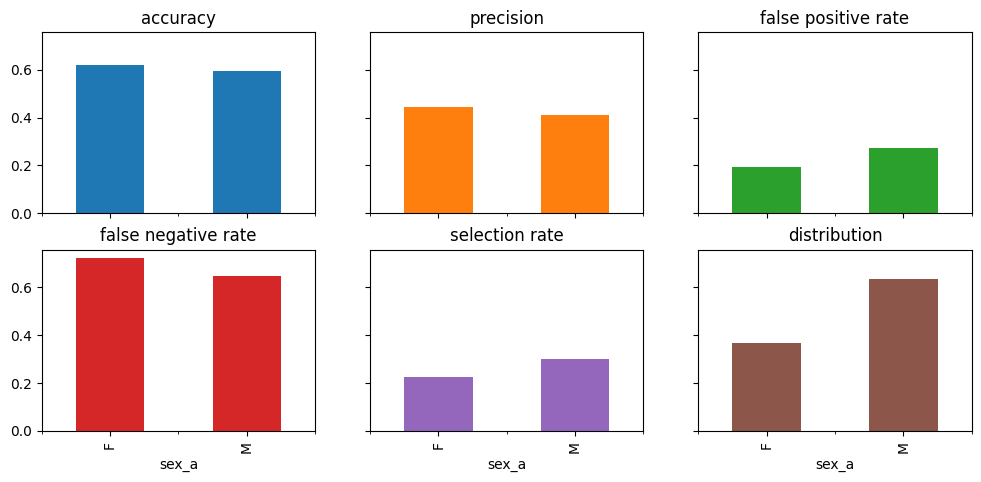

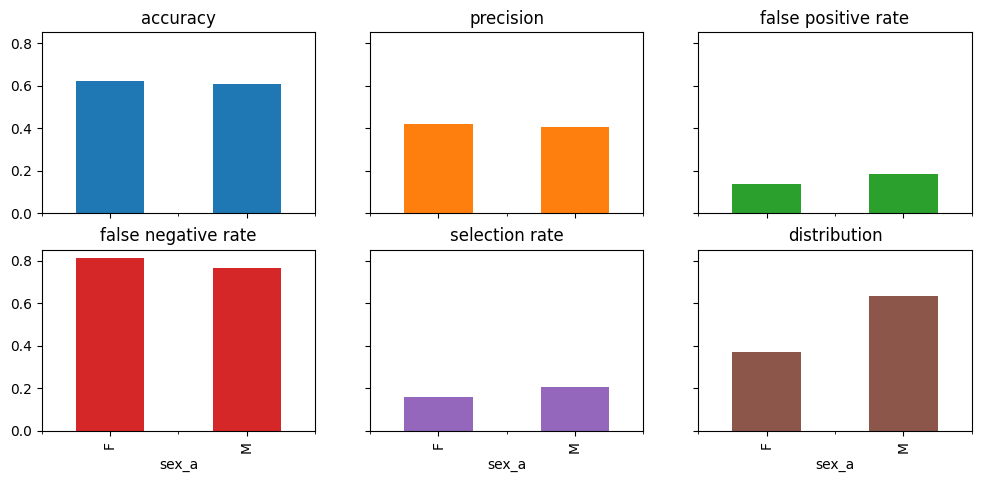

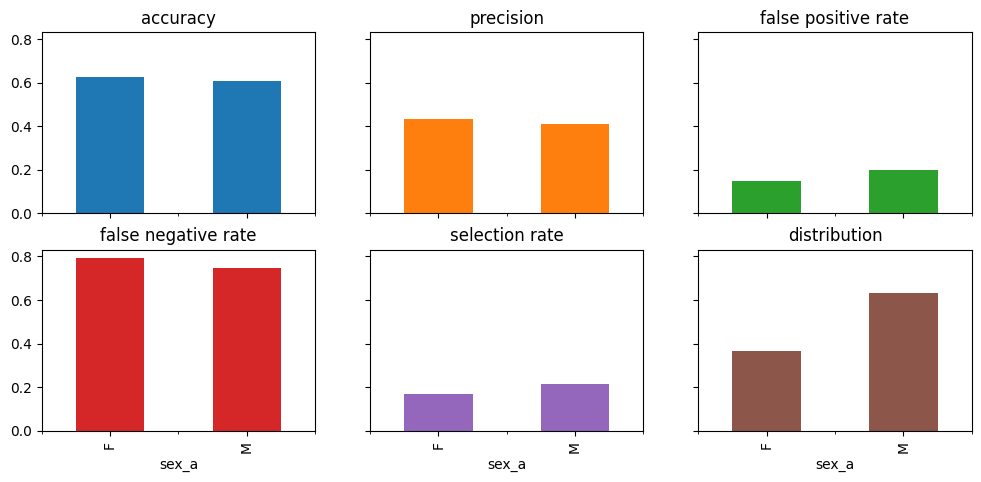

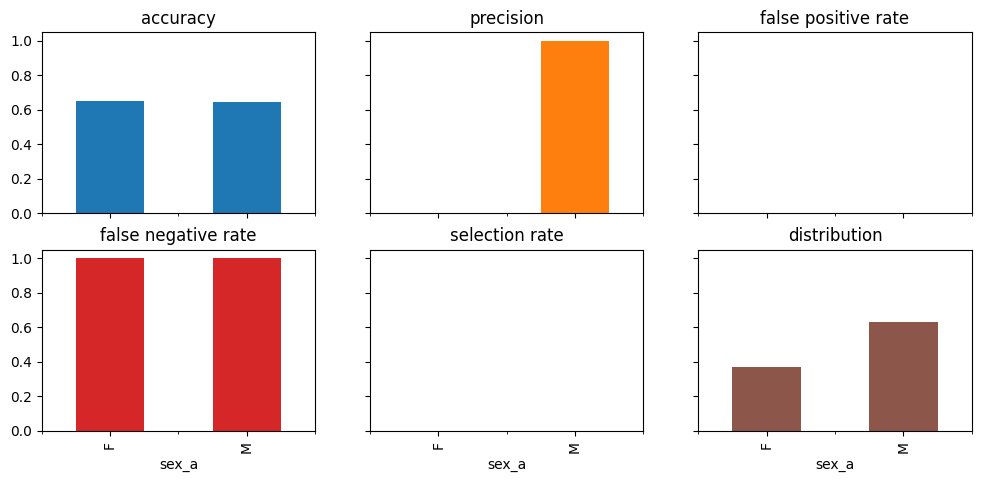

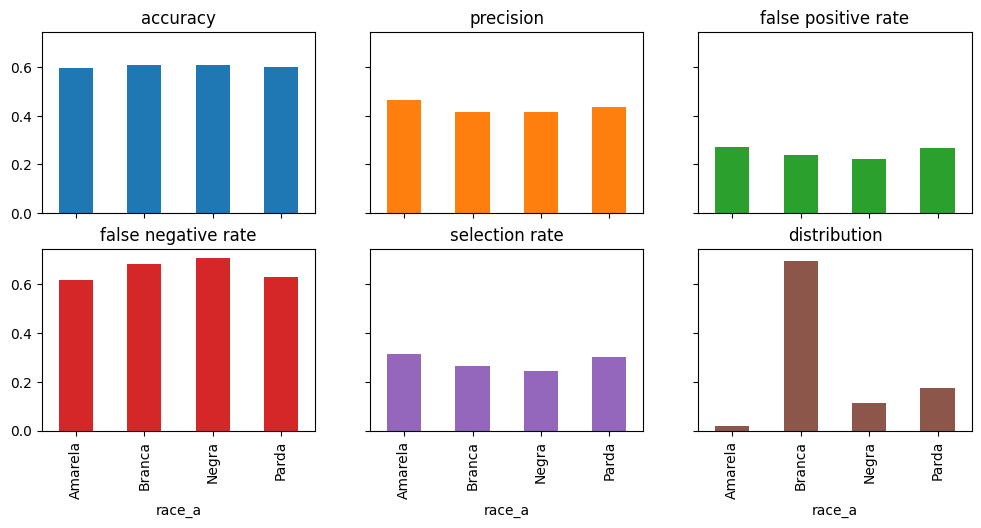

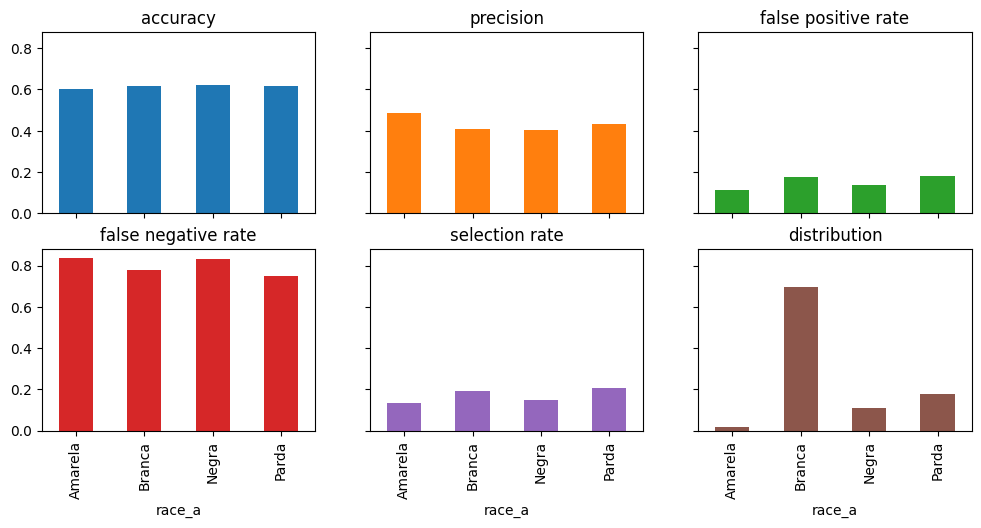

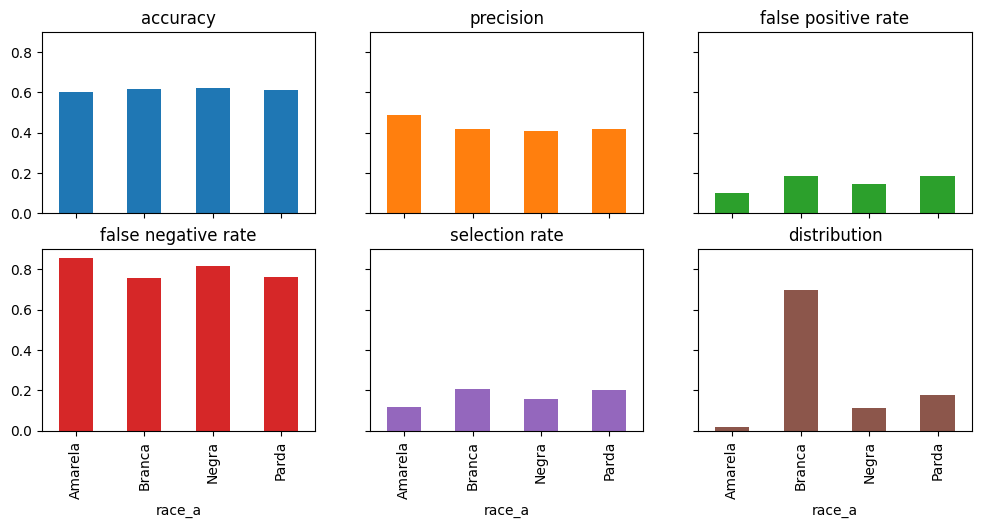

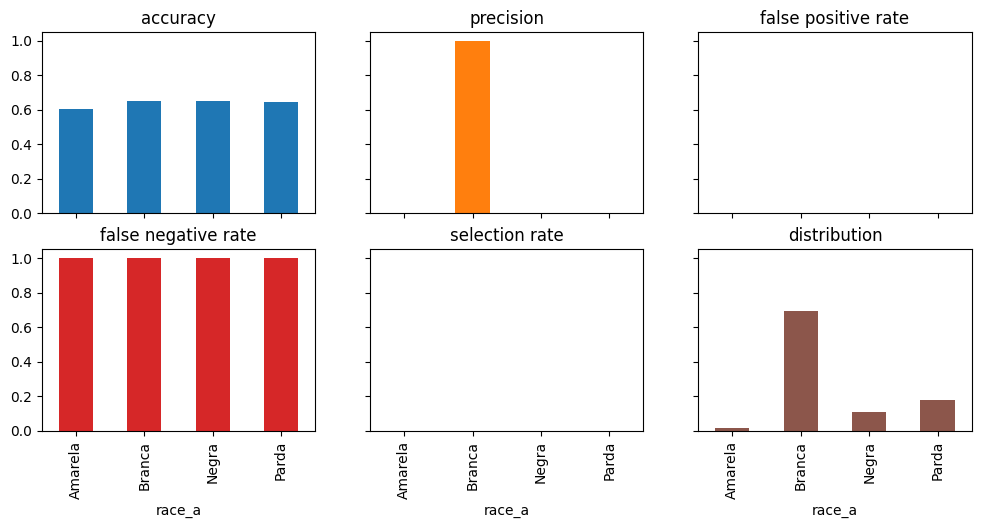

In [75]:
from sklearn.metrics import accuracy_score, precision_score
from fairlearn.metrics import MetricFrame, false_positive_rate, false_negative_rate, selection_rate, count

def metric_frame(y_true, y_pred, sensitive):
    metrics = {
        "accuracy": accuracy_score,
        "precision": precision_score,
        "false positive rate": false_positive_rate,
        "false negative rate": false_negative_rate,
        "selection rate": selection_rate,
        "distribution": lambda t, p: count(t, p) / y_true.shape[0]
    }
    metric_frame = MetricFrame(
        metrics=metrics,
        y_true=y_true,
        y_pred=y_pred,
        sensitive_features=sensitive
    )
    metric_frame.by_group.plot.bar(
        subplots=True,
        layout=[3, 3],
        legend=False,
        figsize=[12, 8],
        sharey=True
    )
    
metric_frame(y_test, y_pred > 0.5, df_pairs_test['sex_a'])
metric_frame(yu_test, yu_pred > 0.5, df_pairs_test_uncorrelated['sex_a'])
metric_frame(y_test, yf_pred > 0.5, df_pairs_test_uncorrelated['sex_a'])
metric_frame(y_test, yf2_pred > 0.5, df_pairs_test_uncorrelated['sex_a'])

metric_frame(y_test, y_pred > 0.5, df_pairs_test['race_a'])
metric_frame(yu_test, yu_pred > 0.5, df_pairs_test_uncorrelated['race_a'])
metric_frame(y_test, yf_pred > 0.5, df_pairs_test_uncorrelated['race_a'])
metric_frame(y_test, yf2_pred > 0.5, df_pairs_test_uncorrelated['race_a'])

In [86]:
# from aif360.sklearn.postprocessing import CalibratedEqualizedOdds
# import numpy as np
# postpros = CalibratedEqualizedOdds(['sex_a', 'race_a'], 'weighted', random_state=1729)
# postpros.fit(
#     X=pd.concat([meta[['sex_a', 'race_a']], pd.DataFrame(y_train_pred, columns=['p'])], axis=1).set_index(['sex_a', 'race_a']),
#     y=y
# )
# ypost_pred = postpros.predict_proba(pd.concat([meta_test['sex_a', 'race_a'], pd.DataFrame(y_pred, columns=['p'])]).set_index(['sex_a', 'race_a']))

KeyError: "None of ['sex_a', 'race_a'] are in the columns"

In [88]:
# from aif360.sklearn.postprocessing import RejectOptionClassifierCV
# postpros2 = RejectOptionClassifierCV(['sex_a', 'race_a'], scoring='average_odds')
# postpros2.fit(
#     pd.concat([meta[['sex_a', 'race_a']], pd.DataFrame(y_train_pred, columns=['p'])], axis=1).set_index(['sex_a', 'race_a']),
#     y
# )
# ypost_pred2 = postpros2.predict_proba(
#     pd.concat([meta_test[['sex_a', 'race_a']], pd.DataFrame(y_pred, columns=['p'])], axis=1).set_index(['sex_a', 'race_a'])
# )

ValueError: 
All the 100 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/aif360/sklearn/postprocessing/reject_option_classification.py", line 118, in fit
    groups, self.prot_attr_ = check_groups(X, self.prot_attr,
                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/pochete/studies/2023s2/mo810/mo810-kidney-waitlist/venv/lib/python3.11/site-packages/aif360/sklearn/utils.py", line 97, in check_groups
    raise ValueError("Expected 2 protected attribute groups, got "
ValueError: Expected 2 protected attribute groups, got Index([ ('M', 'Branca'),   ('M', 'Parda'),  ('F', 'Branca'),   ('M', 'Negra'),
         ('F', 'Parda'),   ('F', 'Negra'), ('M', 'Amarela'), ('F', 'Amarela')],
      dtype='object')


In [ ]:
from fairlearn.postprocessing import ThresholdOptimizer

classifier = train_classifier(X,y)
postpros2 = ThresholdOptimizer(estimator=classifier,constraints='equalized_odds', flip=True, prefit=True)
postpros2.fit(X,y,sensitive_features=meta[['sex_a', 'race_a']])
ypost_pred2 = postpros2.predict(X_test, sensitive_features=meta_test[['sex_a','race_a']], random_state=1729)

In [ ]:
print(f'threshold optimizer - acurácia: {accuracy_score(y_test, ypost_pred2)}, ROC AUC:{roc_auc_score(y_test, ypost_pred2)}')

In [ ]:
from holisticai.bias.mitigation import CalibratedEqualizedOdds

postpros3 = CalibratedEqualizedOdds(cost_constraint='weighted', alpha=0.5)
postpros3.fit(X,y,meta[(meta['sex_a'] == 'M') & (meta['race_a'] == 'Branca')], meta[(meta['sex_a'] != 'M') | (meta['race_a'] != 'Branca')])
ypost_pred3 = postpros3.transform(y_pred > 0.5, list(zip(1-y_pred, y_pred)), meta_test[(meta_test['sex_a'] == 'M') & (meta_test['race_a'] == 'Branca')], meta_test[(meta_test['sex_a'] != 'M') | (meta_test['race_a'] != 'Branca')])

In [ ]:
print(f'calibrated equalized odds - acurácia: {accuracy_score(y_test, ypost_pred3)}, ROC AUC:{roc_auc_score(y_test, ypost_pred3)}')

In [ ]:
from holisticai.bias.mitigation import LPDebiaserBinary

postpros = LPDebiaserBinary(constraint='EqualizedOdds')
postpros.fit(X,y,meta[(meta['sex_a'] == 'M') & (meta['race_a'] == 'Branca')], meta[(meta['sex_a'] != 'M') | (meta['race_a'] != 'Branca')])
ypost_pred = postpros.transform(y_pred > 0.5, list(zip(1-y_pred, y_pred)), meta_test[(meta_test['sex_a'] == 'M') & (meta_test['race_a'] == 'Branca')], meta_test[(meta_test['sex_a'] != 'M') | (meta_test['race_a'] != 'Branca')])

In [ ]:
print(f'lpdebiaser binary - acurácia: {accuracy_score(y_test, ypost_pred)}, ROC AUC:{roc_auc_score(y_test, ypost_pred)}')

In [ ]:
def absolute_avg_odds(X, y_true, y_pred) -> float:
    return abs(y_pred[(~X) & y_true].mean() - y_pred[X & y_true].mean()) / 2 + \
           abs(y_pred[(~X) & (~y_true)].mean() - y_pred[X & (~y_true)].mean()) / 2

def avg_predictive_value_difference(X, y_true, y_pred) -> float:
    return y_true[(~X) & y_pred].mean() - y_true[X & y_pred].mean() / 2 + \
           y_true[(~X) & (~y_pred)].mean() - y_true[X & (~y_pred)].mean() / 2

sex_privileged = df_pairs_test['sex_a'] == 'M'
race_privileged = df_pairs_test['race_a'] == 'Branca'

[
    (absolute_avg_odds(d, t, p), avg_predictive_value_difference(d, t, p))
    for d in [sex_privileged, race_privileged]
    for (t, p) in [(y_test, y_pred > 0.5),
                   (yu_test, yu_pred > 0.5), (y_test, yw_pred > 0.5),
                   (y_test, yf_pred > 0.5), (y_test, yf2_pred > 0.5),
                   (y_test, ypost_pred), (y_test, ypost_pred2),(y_test, ypost_pred3),]
]

[(0.07032728512635297, 0.39995247461562783),
 (0.0011396554536118458, 0.3683898713560534),
 (0.0835641437173133, 0.3860701535802117),
 (0.07032728512635297, 0.39995247461562783),
 (0.00941395966964724, 0.38938685112533145),
 (0.002832018069999956, 0.37261971815311784),
 (0.022874999711724353, 0.37634560993617683),
 (0.00941395966964724, 0.38938685112533145)]